# <span style='color:blue'> LAB 6: </span>
# <span style='color:blue'> ADVANCED RECURRENT NEURAL NETWORKS </span>

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns

## <span style='color:red'> Part 2: Encoder-Decoder in PyTorch </span>
## <span style='color:red'> Signal Prediction </span>

In [2]:
# Seaborn plot styling
sns.set(style = 'white', font_scale = 2)

## Prepare Data

In [3]:
def generate_noisy_signal(datapoints_num, tf):
    
    # Create time domain vector according to datapoints_num
    t = np.linspace(0., tf, datapoints_num)
    
    # Create noisy wave (sin + cos + gaussian noise)
    y = np.sin(2. * t) + 0.5 * np.cos(t) + np.random.normal(0., 0.2, datapoints_num)
    
    # Reshape y in vertical orientation, i.e., (datapoints_num, 1) shape
    return y.reshape(-1, 1)

In [4]:
def generate_input_output_seqs(y, encoder_inputseq_len, decoder_outputseq_len, stride = 1, num_features = 1):
  
    L = y.shape[0] # Length of y
    
    # Calculate how many input/target sequences there will be based on the parameters and stride
    num_samples = (L - encoder_inputseq_len - decoder_outputseq_len) // stride + 1
    
    # Numpy zeros arrray to contain the input/target sequences
    # Note that they should be in (num_samples, seq_len, num_features/time step) format
    train_input_seqs = np.zeros([num_samples, encoder_inputseq_len, num_features])
    train_output_seqs = np.zeros([num_samples, decoder_outputseq_len, num_features])    
    
    # Iteratively fill in train_input_seqs and train_output_seqs
    # See slide 17 of lab 7 to get an idea of how input_seqs and output_seqs look like
    for ff in np.arange(num_features):
        
        for ii in np.arange(num_samples):
            
            start_x = stride * ii
            end_x = start_x + encoder_inputseq_len
            train_input_seqs[ii, :, ff] = y[start_x:end_x, ff]

            start_y = stride * ii + encoder_inputseq_len
            end_y = start_y + decoder_outputseq_len 
            train_output_seqs[ii, :, ff] = y[start_y:end_y, ff]

    return train_input_seqs, train_output_seqs

In [5]:
# Define encoder/decoder sequence lengths and testing sequencce length
encoder_inputseq_len = 5 
decoder_outputseq_len = 2 
testing_sequence_len = 50

# Generate noisy signal
y = generate_noisy_signal(datapoints_num = 2000, tf = 80 * np.pi)

# Using the all the datapoints except for testing sequence (last 50 datapoints) for training
y_train = y[:-testing_sequence_len]

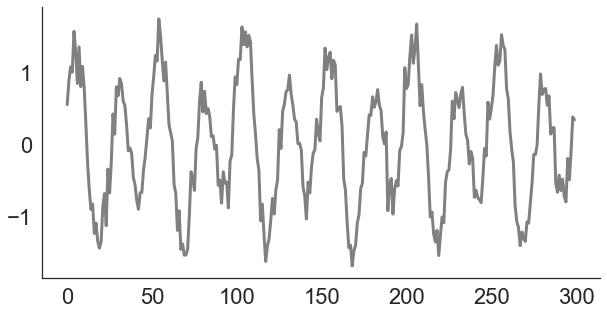

In [6]:
# Let's visualize the last 300 datapoints of our training data
plt.figure(figsize = (10, 5))

plt.plot(y_train[-300:], linewidth = 3, color = 'grey')
sns.despine()

In [7]:
# Generate encoder input seqs and decoder output seqs
train_input_seqs, train_output_seqs = generate_input_output_seqs(y = y_train,
                                                                 encoder_inputseq_len = encoder_inputseq_len,
                                                                 decoder_outputseq_len = decoder_outputseq_len,
                                                                 stride = 1,
                                                                 num_features = 1)

In [8]:
# Check the dimensions of encoder input seqs and decoder output seqs
print("Encoder Training Inputs Shape: ", train_input_seqs.shape)
print("Decoder Training Outputs Shape: ", train_output_seqs.shape)

Encoder Training Inputs Shape:  (1944, 5, 1)
Decoder Training Outputs Shape:  (1944, 2, 1)


## Define Model

In [ ]:
class Encoder(torch.nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        
        super(Encoder, self).__init__()
        
        # Using LSTM for Encoder with batch_first = True

        self.lstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                                  num_layers = num_layers, 
                                  batch_first = True)

    def forward(self, input_seq, hidden_state):
        
        lstm_out, hidden = self.lstm(input_seq, hidden_state)
        
        return lstm_out, hidden     

class Decoder(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        
        super(Decoder, self).__init__()
        
        # Using LSTM for Decoder with batch_first = True
        # fc_decoder for converting hidden states -> single number

        self.lstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                                  num_layers = num_layers,
                                  batch_first = True)
        
        self.fc_decoder = torch.nn.Linear(hidden_size, output_size)     

    def forward(self, input_seq, encoder_hidden_states):
        
        lstm_out, hidden = self.lstm(input_seq, encoder_hidden_states)
        output = self.fc_decoder(lstm_out)     
        
        return output, hidden

class Encoder_Decoder(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, decoder_output_size, num_layers):
        
        # Combine Encoder and Decoder classes into one

        super(Encoder_Decoder, self).__init__()

        self.Encoder = Encoder(input_size = input_size, hidden_size = hidden_size, 
                               num_layers = num_layers)
        
        self.Decoder = Decoder(input_size = input_size, hidden_size = hidden_size, 
                               output_size = decoder_output_size, num_layers = num_layers)

## Define Hyperparameters

In [ ]:
# Fix random seed
torch.manual_seed(55)

# Using input_size = 1 (# of features to be fed to RNN per timestep)
# Using decoder_output_size = 1 (# of features to be output by Decoder RNN per timestep)
Encoder_Decoder_RNN = Encoder_Decoder(input_size = 1, hidden_size = 15, 
                                      decoder_output_size = 1, num_layers = 1)

# Define learning rate + epochs
learning_rate = 0.01         
epochs = 50

# Define batch size and num_features/timestep (this is simply the last dimension of train_output_seqs)
batchsize = 5
num_features = train_output_seqs.shape[2]

# Define loss function/optimizer
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Encoder_Decoder_RNN.parameters(), lr=learning_rate)

Encoder_Decoder_RNN

## Identify Tracked Values

In [ ]:
# Empty Python list to keep track of training loss
train_loss_list = []

## Train Model

In [ ]:
# Convert training dataset into torch tensors
train_input_seqs = torch.from_numpy(train_input_seqs).float()
train_output_seqs = torch.from_numpy(train_output_seqs).float()

# Split the training dataset to mini-batches
# Skipping the last mini-batch since its size can be smaller than the set batchsize
train_batches_features = torch.split(train_input_seqs, batchsize)[:-1]
train_batches_targets = torch.split(train_output_seqs, batchsize)[:-1]

# Total number of mini-batches in the training set
batch_split_num = len(train_batches_features)

In [ ]:
for epoch in range(epochs): # For each epoch
    
    for k in range(batch_split_num): # For each mini_batch
        
        # initialize hidden states to Encoder
        hidden_state = None
        
        # initialize empty torch tensor array to store decoder output sequence
        decoder_output_seq = torch.zeros(batchsize, decoder_outputseq_len, num_features)
        
        # empty gradient buffer
        optimizer.zero_grad()
        
        # Feed k-th mini-batch for encoder input sequences to encoder with hidden state
        encoder_output, encoder_hidden = Encoder_Decoder_RNN.Encoder(train_batches_features[k], hidden_state)
        # Re-define the resulting encoder hidden states as input hidden states to decoder
        decoder_hidden = encoder_hidden
        
        # Initial input to decoder is last timestep feature from the encoder input sequence
        decoder_input = train_batches_features[k][:, -1, :]
        # The extracted feature is 2D so need to add additional 3rd dimension 
        # to conform to (sample size, seq_len, # of features)
        decoder_input = torch.unsqueeze(decoder_input, 2)
        
        # Populating the decoder output sequence
        for t in range(decoder_outputseq_len): # for each timestep in output sequence
            
            # Feed in the decoder_input and decoder_hidden to Decoder, get new output and hidden states
            decoder_output, decoder_hidden = Encoder_Decoder_RNN.Decoder(decoder_input, decoder_hidden)
            
            # Populate the corresponding timestep in decoder output sequence 
            decoder_output_seq[:, t, :] = torch.squeeze(decoder_output, 2)
            
            # We are using teacher forcing so using the groundtruth training target as the next input        
            decoder_input = train_batches_targets[k][:, t, :]
            
            # The extracted feature is 2D so need to add additional 3rd dimension 
            # to conform to (sample size, seq_len, # of features)
            decoder_input = torch.unsqueeze(decoder_input, 2)
        
        # Compare the predicted decoder output sequence aginast the target sequence to compute the MSE loss
        loss = loss_func(torch.squeeze(decoder_output_seq), torch.squeeze(train_batches_targets[k]))
        
        # Save the loss
        train_loss_list.append(loss.item())
        
        # Backprop
        loss.backward()
        
        # Update the RNN
        optimizer.step()
    
    print("Averaged Training Loss for Epoch ", epoch,": ", np.mean(train_loss_list[-batch_split_num:]))

## Visualize & Evaluate Model

In [ ]:
plt.figure(figsize = (12, 7))

plt.plot(np.convolve(train_loss_list, np.ones(100), 'valid') / 100, 
         linewidth = 3, label = 'Rolling Averaged Training Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()

In [ ]:
# Define the test sequence (last 50 datapoints in our case)
test_input_seq = y[-testing_sequence_len:]

In [ ]:
# Let's visualize our test sequence
plt.figure(figsize = (10, 5))
plt.plot(test_input_seq, linewidth = 3)
plt.title('Test Sequence')
sns.despine()

### Generate signal predictions for testing sequence with trained Encoder-Decoder

In [ ]:
# Convert test sequence to tensor
test_input_seq = torch.from_numpy(test_input_seq).float()

# initialize empty torch tensor array to store decoder output sequence
# This should be the same size as the test sequence
decoder_output_seq = torch.zeros(testing_sequence_len, num_features)

# First n-datapoints in decoder output sequence = First n-datapoints in ground truth test sequence
# n = encoder_input_seq_len
decoder_output_seq[:encoder_inputseq_len] = test_input_seq[:encoder_inputseq_len]

# Initialize index for prediction
pred_start_ind = 0

# Activate no_grad() since we aren't performing backprop
with torch.no_grad():
    
    # Loop continues until the RNN prediction reaches the end of the testing sequence length
    while pred_start_ind + encoder_inputseq_len + decoder_outputseq_len < testing_sequence_len:
        
        # initialize hidden state for encoder
        hidden_state = None
        
        # Define the input to encoder
        input_test_seq = decoder_output_seq[pred_start_ind:pred_start_ind + encoder_inputseq_len]
        # Add dimension to first dimension to keep the input (sample_size, seq_len, # of features/timestep)
        input_test_seq = torch.unsqueeze(input_test_seq, 0)
        
        # Feed the input to encoder and set resulting hidden states as input hidden states to decoder
        encoder_output, encoder_hidden = Encoder_Decoder_RNN.Encoder(input_test_seq, hidden_state)
        decoder_hidden = encoder_hidden
        
        # Initial input to decoder is last timestep feature from the encoder input sequence 
        decoder_input = input_test_seq[:, -1, :]
        # Add dimension to keep the input (sample_size, seq_len, # of features/timestep)
        decoder_input = torch.unsqueeze(decoder_input, 2)
        
        # Populate decoder output sequence
        for t in range(decoder_outputseq_len):
            
            # Generate new output for timestep t
            decoder_output, decoder_hidden = Encoder_Decoder_RNN.Decoder(decoder_input, decoder_hidden)
            # Populate the corresponding timestep in decoder output sequence
            decoder_output_seq[pred_start_ind + encoder_inputseq_len + t] = torch.squeeze(decoder_output)
            # Use the output of the decoder as new input for the next timestep
            decoder_input = decoder_output
        
        # Update pred_start_ind
        pred_start_ind += decoder_outputseq_len

In [ ]:
# Compare the RNN prediction (decoder output sequence) vs the ground truth sequence
plt.figure(figsize = (10, 5))

plt.plot(test_input_seq, linewidth = 3, label = 'GroundTruth')
plt.plot(decoder_output_seq, linewidth = 3, label = 'RNN Predicted')
plt.title('RNN Predicted vs GroundTruth')
plt.legend()
sns.despine()